### BERT 양쪽을 문맥을 이해
    - 빈칸채우기 

####
    - 데이터
    - Hugging Face Transformers Pipeline(간단한 api)    
    - 토크나이져 ( 텍스트 -> 토큰 ->숫자 ID)
    - 사전학습된 모델(BERT , GPT-2, DistilBERT 등)
    - 예측 결과(감성분석, 텍스트 생성, 문장 유사도)
    - 후처리 평가(확률 변환, 정확도 계산)

```
"I went to the [MASK] to buy some milk"
BERT 예측 : [MASK] = "store" ( 앞뒤 문맥 buy, milk를 보고 추론)
```

### 사전학습 방법
    - MLM(Masked Language Model) : 문장의 15% 단어를 MASK 처리한다음 예측
    - NSP(Next Stentece Prediction) : 두 문장이 연결되는지 판단
```
사전학습(대규모 텍스트)
[CLS] token 추가
특정 태스크 레이블로 학습(감성분석, QA 등)
```    

### DistilBERT
    - BERT 압축버전 : 속도는 2배 빠르다, 성능은 95% 유지함
    - 두꺼운 교과서(BERT)의 핵심만 추린 요약본(DistilBERT)
### 지식증류(Knowledge Distillation)
    - Teacher 모델(BERT) : 소프트레이블 생성(확률분포)
    - Student 모델(DistilBERT) : Teacher 출력을 모방
### GPT-2
    - 이전단어들을 보고 다음 단어를 예측    
    - 단방향 Attention:
    - Zero-shot Learning : 특정 태스트 학습 없이도 수행 가능
    - GPT 시리즈
        - GPT -1 : 117M 파라메터
        - GPT -2 : 1.5B 파라메터
        - GPT -3 : 175B 파라메터(Few-shot Learning)
        - GPT -4 : 멀티모달


In [4]:
import numpy as np
def softmax(logits):
    '''
    로짓을 확률 분포로 변환
    Args:
        logits : 모델의 출력 점수( [2.5,1.0,0.5])
    returns:
        확률 분포(합이 1인 배열)
    '''
    # 수치 안정성을 위해 최대값을 빼줌(오버플로우 방지)
    exp_logits = np.exp(logits - np.max(logits))
    return exp_logits / np.sum(exp_logits)
logits = np.array([2.5,1.0,0.5])    
probs = softmax(logits)
print(f'logits : {logits}')
print(f'softmax : {probs}')
print(f'softmax sum : {np.sum(probs)}')

logits : [2.5 1.  0.5]
softmax : [0.73612472 0.16425163 0.09962365]
softmax sum : 0.9999999999999999


### WordPiece   Word + Piece
    - 단어를 자주 등장하는 조각(piece) 단위로 잘라서 처리
    - 기존토크나이져 대비 --> 더 잘게 쪼개자. (Subword)
    - playing ----->  play + ##ing    ## 앞 조각에 붙는 서브워드 라는 의미
    - 득템   ---------> 득 + 템

WordPiece 토큰화 시뮬레이션

In [5]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from transformers import AutoTokenizer
# BERT 토크나이져 로드
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# 테스트 문장
sentence = 'I love natural language processing!'
# 토큰화
tokens = tokenizer.tokenize(sentence)
token_ids = tokenizer.encode(sentence)
# 디코딩
decoded = tokenizer.decode(token_ids)
print(f'원본문장 : {sentence}')
print(f'토큰목록 : {tokens}')
print(f'토큰ID : {token_ids}')
print(f'디코딩결과 : {decoded}')

print(f'CSL토큰 : {tokenizer.cls_token} -> {tokenizer.cls_token_id}')
print(f'SEP토큰 : {tokenizer.sep_token} -> {tokenizer.sep_token_id}')
print(f'PAD토큰 : {tokenizer.pad_token} -> {tokenizer.pad_token_id}')

c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\31799\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an adminis

원본문장 : I love natural language processing!
토큰목록 : ['i', 'love', 'natural', 'language', 'processing', '!']
토큰ID : [101, 1045, 2293, 3019, 2653, 6364, 999, 102]
디코딩결과 : [CLS] i love natural language processing! [SEP]
CSL토큰 : [CLS] -> 101
SEP토큰 : [SEP] -> 102
PAD토큰 : [PAD] -> 0


BERT로 문장 유사도 판단

In [7]:
%pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# AutoTokenizer  지정한 모델 이름에 맞게 토크나이져를 자동으로 불러오는 클래스
# AutoModelForSequenceClassification : 문장분류용 BERt모델을 자동으로 로드
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 모델 로드
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased-finetuned-mrpc')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased-finetuned-mrpc')
def check_similarity(sentence1, sentence2):
    '''
    두 문장의 의미적 유사도를 판단
    Returns:
        유사확률(0~1 사이 값)
    '''
    #1 토큰화
    inputs = tokenizer(sentence1,sentence2,return_tensors='pt')
    #2 모델추론 
    with torch.no_grad():
        logits = model(**inputs).logits
    #3 softmax로 확률 변환
        probs = torch.softmax(logits, dim=1)[0]  # 0은 배치 배치를 제거
    #4 결과 반환
    return{
        'not_similar' : probs[0].item(),
        'similar' : probs[1].item()
    }
# 테스트 케이스
test_cases = [
    ("The cat is on the mat", "A feline is sitting on a rug"),
    ("I love pizza", "Python is a programming language"),
    ("He runs fast", "She walks slowly")
]
for sent1,sent2 in test_cases:
    result = check_similarity(sent1,sent2)
    print(f'문장1 : {sent1}')
    print(f'문장2 : {sent2}')
    print(f"유사확률 : {result['similar']:.2f}\n")

c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\31799\.cache\huggingface\hub\models--bert-base-cased-finetuned-mrpc. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fal

문장1 : The cat is on the mat
문장2 : A feline is sitting on a rug
유사확률 : 0.90

문장1 : I love pizza
문장2 : Python is a programming language
유사확률 : 0.04

문장1 : He runs fast
문장2 : She walks slowly
유사확률 : 0.11



GPT-2
```
다음 단어 후보와 확률
The cat is on the 다음에 단어 후보 와 확률
mat             0.4
roof            0.25
bed             0.15
chair           0.10
floor           0.05

top-k  3  mat roof  bed
top-p  0.8

mat  0.40  -> 누적 0.40
roof 0.25  -> 누적 0.65
bed 0.15   -> 누적 0.80 
```

In [9]:
from transformers import GPT2LMHeadModel,GPT2Tokenizer
import torch
# 모델 로드
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')
def generate_text(prompt, max_length = 30):
    '''
    프롬프트 기반으로 텍스트 생성
    Args:
        prompt : 시작문장
        max_length : 최대 토큰수
    '''
    #1 입력 토큰화
    input_ids = tokenizer.encode(prompt,return_tensors='pt')
    #2 생성(다양한 전략)
    with torch.no_grad():  # 추론(평가)모드
        output = model.generate(
            input_ids,
            max_length = max_length,
            num_return_sequences = 1, # 생성할 문장 수
            temperature=0.8, # 창의성 조절
            top_k=50, # 샘플링전략  상위 k개의 단어만 선택
            top_p=0.95, # 누적확률 p 이상 단어만
            do_sample = True,  #확률적 셈플링
            pad_token_id = tokenizer.eos_token_id  # gpt2는 eos 토큰을 사용
        )

    #3 디코딩
    generated_txt = tokenizer.decode(output[0],skip_special_tokens=True)
    return generated_txt
prompts = [
    "Once upon a time",
    "In the year 2050,",
    "The secret to happiness is"
]
for prompt in prompts:
    result = generate_text(prompt)
    print(f'prompt : {prompt}')
    print(f'생성 : {result}\n')

c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\31799\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP 

prompt : Once upon a time
생성 : Once upon a time, there were a few men with rifles in the middle of the street. They were very good looking and very sharp. I noticed

prompt : In the year 2050,
생성 : In the year 2050, we will see another high-profile attempt to change that. We're going to start with a revolution in the way medicine is

prompt : The secret to happiness is
생성 : The secret to happiness is not that you are a beautiful, sexy person. It is that you know how to talk and smile.

What you



- BertTokenizer : 직접호출
    - BERT 전용
    - bert-base-uncased,  bert-base-cased 등 BERT계열만 지원
    - 다른 모델에서는 사용 불가
    - 모델전화시 코드 수정
- AutoTokenizer : 자동선택
    - BERT RoBERTa, GPT-2, T5 다양한 모델 지원
    - from_pretraned에 모델이름을 넣으면 
    - 어떤 클래스가 선택되었는지 모름->세부구현시 세부옵션 확인

토큰목록 : ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '[SEP]']


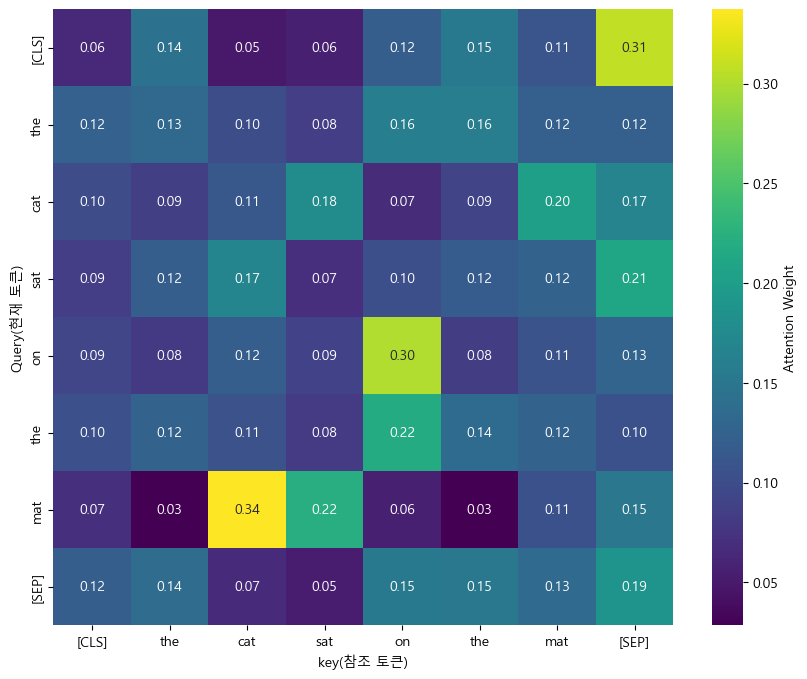

In [22]:
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

#self-Attention 가중치 시각화
sentence = 'The cat sat on the mat'
# 1 토큰화
inputs = tokenizer(sentence,return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
# 2 모델 실행(Attention 추출)
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  #12개 레이어의 Attention
# 3 첫번째 레이어, 첫 번째 헤드 Attention 시각화
attention = attentions[0][0,0].numpy()  
plt.figure(figsize=(10,8))
sns.heatmap(
    attention,
    xticklabels=tokens,
    yticklabels=tokens,
    cmap = 'viridis',
    annot = True,
    fmt = '.2f',
    cbar_kws={'label':'Attention Weight'}
)
plt.xlabel('key(참조 토큰)')
plt.ylabel('Query(현재 토큰)')

print(f'토큰목록 : {tokens}')
# print(f'Attention 행렬 크기 : {attentions.shape}')

In [12]:
# Bert 모델을 이용해서 영화리뷰 감성분석
# 데이터셋 : NLTK movie_reviews
# 모델 DistilBERT
# 평가 : 분류리포트
import nltk
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [13]:
nltk.download('movie_reviews',quiet=True)

True

In [14]:
reviews = [movie_reviews.raw(id) for id in movie_reviews.fileids()]
categoris = [ movie_reviews.categories(id)[0] for id in movie_reviews.fileids() ]

In [15]:
# pos 1  eng 0
y =  np.array([1 if ca == 'pos' else 0 for ca in categoris])
x_train,x_test,y_train,y_test = train_test_split(reviews,y, stratify=y,random_state=42)

In [16]:
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\31799\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is n

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [20]:
# 예측함수
def predict_sentiment(texts, batch_size=0):
    '''
    배치단위로 감성 예측
    Args:
        texts: 리뷰 텍스트 리스트
        batch_size:한번에 처리할 샘플 수
    Returns:
        예측 레이블 배열
    '''
    model.eval()
    predictions = []
    #배치단위 처리
    num_batchs = (len(texts) + batch_size-1) // batch_size  # 103  20      (103+19)//20   (122)//20 
    with torch.no_grad():
        for i in tqdm(range(num_batchs), desc='예측 중'):
            # 배치추출
            batch_text = texts[ i*batch_size : (i+1)*batch_size  ]
            # 토큰화(최대 512토큰, 패딩적용)
            inputs = tokenizer(
                batch_text,
                truncation=True,
                padding=True,
                max_length = 512,
                return_tensors='pt'
            )
            inputs = { k: v.to(device) for k, v in inputs.items()  }
            # 모델 예측
            outputs = model(**inputs)
            logits = outputs.logits
            # 확률변환
            prebs = F.softmax(logits,dim=1)
            preds = prebs.argmax(dim=1).cpu().numpy()
            predictions.extend(preds)
    return np.array(predictions)

In [21]:
y_pred = predict_sentiment(x_test, batch_size=16)
print(classification_report(y_test,y_pred,target_names=['neg','pos']))

예측 중: 100%|██████████| 32/32 [01:12<00:00,  2.27s/it]

              precision    recall  f1-score   support

         neg       0.76      0.92      0.83       250
         pos       0.90      0.70      0.79       250

    accuracy                           0.81       500
   macro avg       0.83      0.81      0.81       500
weighted avg       0.83      0.81      0.81       500



In [23]:
# AutoTokenizer / Automodel... GPT-2 텍스트 생성
# 생성된 문장과 원본문장을 Bert를 이용해서 문장 유사도 계산

In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
# AutoModelForCausalLM 시퀀스의 다음단어를 앞 단어기반으로 한단계씩 예측  (자동 회귀 모델)  GPT GPT-Neo.. 등
# AutoModelForSequenceClassification  문장 문서분류(Classification) -> 감성분석 스펨 문장유사도 등..  BERT RoBERTa DistilBERT
import torch
#  텍스트 생성  GPT-2
GPT_MODEL_NAME = 'gpt2'
gpt_tokenizer = AutoTokenizer.from_pretrained(GPT_MODEL_NAME)
gpt_model = AutoModelForCausalLM.from_pretrained(GPT_MODEL_NAME)

prompt = 'once upon a time'

def generate_text(prompt,max_length=30):
    input_ids = gpt_tokenizer(prompt, return_tensors='pt').input_ids
    with torch.no_grad():
        output = gpt_model.generate(
            input_ids,
            max_length = max_length,
            num_return_sequences=1,
            temperature=0.8,
            top_k=50,
            top_p=0.95,
            do_sample=True,
            pad_token_id=gpt_tokenizer.eos_token_id
          )
    return gpt_tokenizer.decode(output[0],skip_special_tokens=True)

# BERT 모델(문장 유사도 MRPC)
BERT_MODEL_NAME = 'bert-base-cased-finetuned-mrpc'
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME)
def sentence_similarity(sent1,sent2):
    inputs = bert_tokenizer(sent1, sent2, return_tensors='pt')
    with torch.no_grad():
        logits = bert_model(**inputs).logits
        probs = torch.softmax(logits,dim=-1)[0]
    return{
        'not_similar' : probs[0].item(),
        'similar' : probs[1].item()
    }

prompts = [
    "Once upon a time",
    "In the year 2050,",
    "The secret to happiness is"
]

for prompt in prompts:

    print(f'프롬프트 : {prompt}')
    generated_text = generate_text(prompt)
    print(f'생성 : {generated_text}')
    similarity = sentence_similarity(prompt, generated_text)
    print(f'유사도 : {similarity}')

프롬프트 : Once upon a time
생성 : Once upon a time, you were in a city where life was still going on, where you could have a job, and I was telling my friend
유사도 : {'not_similar': 0.9003036618232727, 'similar': 0.09969639778137207}
프롬프트 : In the year 2050,
생성 : In the year 2050, we will see a further increase in the number of people who have been living with HIV/AIDS in the country."


유사도 : {'not_similar': 0.9586114883422852, 'similar': 0.04138854146003723}
프롬프트 : The secret to happiness is
생성 : The secret to happiness is love, and to love it all you have to do is to put on the best outfit you can.

The best
유사도 : {'not_similar': 0.9390103816986084, 'similar': 0.06098955497145653}


파인 튜닝 - 추가 학습

In [6]:
data = {
    'text': [
        "This product exceeded my expectations!",
        "Very disappointed with the quality.",
        "Good value for money.",
        "Worst purchase ever.",
        "Highly recommended!",
        "Not worth the price."
    ],
    'label': [1, 0, 1, 0, 1, 0]  # 1: 긍정, 0: 부정
}